In [200]:
def notes_for_code():
    '''
    Stock Universe: SP500, NYSE, NASDAQ, NYSEMKT (wiki, eoddata.com)
    Global Filter: manually removed all stocks with . or - ==> 6.5% of stocks
    '''

In [210]:
from pandas.io.data import DataReader
import datetime as dt
from time import time
import pandas as pd
import numpy as np
import glob    
from scipy import stats
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [202]:
''' Datasets and Inputs: get and save historical price data from Yahoo '''
def get_price_data(stock_universe, start_date, end_date, keep_existing_prices):  
    # start the clock
    start = time()

    # get ticker list for stock universe
    ticker_list = get_ticker_list(stock_universe)
    
    # convert start_date and end_date to datetime objects
    info_start = dt.datetime(int(start_date[:4]), int(start_date[5:7]), int(start_date[8:10]))
    info_end = dt.datetime(int(end_date[:4]), int(end_date[5:7]), int(end_date[8:10]))

    # get file list of stocks with existing price data
    files = get_tickers_with_existing_price_data()
    
    # only keep stocks with this many market days 
    market_days = int(pd.Timedelta(info_end - info_start, unit='Y').days * (250/365.0))
           
    # loop through ticker list and count stocks with price data
    retry_ticker_list, stock_data_counter = [], 0
    for ticker in ticker_list:
        try:
            # skip ticker if we already have prices and we are going to keep existing prices for this stock
            if ticker in files and keep_existing_prices: continue 
        
            # get prices from pandas datareader
            prices = DataReader(ticker, 'yahoo', info_start, info_end)

            # only save stocks with complete price data for date range
            if len(prices) < market_days:
                retry_ticker_list.append(ticker)
                continue 
            prices.to_csv("data/price_data/" + ticker + ".csv", sep=',')
            stock_data_counter += 1
            
        except Exception, e:
            print 'Yahoo not responding for ticker: {}'.format(ticker)
            retry_ticker_list.append(ticker)
    
    total_time = time() - start
    print "\nStocks with Price Data: " + str(stock_data_counter) + ", Need to Retry: " + str(len(retry_ticker_list))
    print '\nNeed to retry these tickers: ', retry_ticker_list,'\n'
    print 'Price Data in {:.2f} seconds. {:.2f} seconds per stock.'.format(total_time, total_time/stock_data_counter)
    return retry_ticker_list

def get_ticker_list(stock_universe):
    # get ticker list from stock universe
    file_name = ["SP500_tickers.csv","NYSE_tickers.csv","NASDAQ_tickers.csv","NYSEMKT_tickers.csv"][stock_universe]
    ticker_list = pd.read_csv("data/tickers/"+file_name, header=0).values[:,1]
    return ticker_list

def get_tickers_with_existing_price_data():
    # get file list of stocks with existing price data
    files = glob.glob('data/price_data/*.csv')
    for i in range(len(files)): files[i] = files[i][16:-4]
    return files

# select stock universe: ['SP500', 'NYSE', 'NASDAQ', 'NYSEMKT']
stock_universe = 0
    
# define date range (10 years of data)
start_date, end_date = '2005-09-30','2016-11-01'

# get price data
price_data = True
if price_data: retry_tickers = get_price_data(stock_universe, start_date, end_date, keep_existing_prices=False)

Yahoo not responding for ticker: ACE
Yahoo not responding for ticker: ACX

Stocks with Price Data: 5, Need to Retry: 3

Need to retry these tickers:  ['ACE', 'GRPN', 'ACX'] 

Price Data in 4.69 seconds. 0.94 seconds per stock.


In [203]:
''' Feature Engineering: create matrix of features '''
def create_feature_matrix(dates,TRet_list):  
    # start the clock
    start = time()
    
    # create dictionary to hold dataframes for all features: dimension = [dates x tickers]
    features = dict()

    # get file list of stocks with existing price data
    symbols = get_tickers_with_existing_price_data()
    if 'SPY' not in symbols: symbols.insert(0,'SPY') # reference stock

    # create empty dataframe
    df_vol = pd.DataFrame(index=dates)    
    df_close = pd.DataFrame(index=dates)
    
    # read in more stocks
    for symbol in symbols:
        symbol_path = 'data/price_data/' + symbol + '.csv'
        
        # rename to prevent clash
        df_vol_temp = pd.read_csv(symbol_path,index_col='Date',parse_dates=True,usecols=['Date','Volume'],na_values=['nan'])
        df_vol_temp = df_vol_temp.rename(columns={'Volume':symbol})
        df_vol = df_vol.join(df_vol_temp,how='left')
        if symbol == 'SPY': df_vol = df_vol.dropna(subset=['SPY']) # non trading days
    
        # rename to prevent clash
        df_close_temp = pd.read_csv(symbol_path,index_col='Date',parse_dates=True,usecols=['Date','Adj Close'],na_values=['nan'])
        df_close_temp = df_close_temp.rename(columns={'Adj Close':symbol})
        df_close = df_close.join(df_close_temp,how='left')
        if symbol == 'SPY': df_close = df_close.dropna(subset=['SPY']) # non trading days 
    
    df_vol = df_vol / (10**6)
    df_vol = df_vol.sort_index(ascending=False) 
    display(df_vol.ix[:10,:10])
    features['Volume'] = df_vol
    print 'df_vol shape: ', df_vol.shape
    
    df_close = df_close.sort_index(ascending=False) 
    display(df_close.ix[:10,:10])
    features['Close'] = df_close
    print 'df_close shape: ', df_close.shape,'\n'
    
    for i in TRet_list: features['TRet'+str(i)] = df_close.shift(-1) / df_close.shift(-(i+1)) - 1
    
    display(features['TRet5'].ix[:10,:10])
    print 'TRet5 shape: ', features['TRet5'].shape,'\n'
    
    total_time = time() - start
    print 'Feature Data in {:.2f} seconds. {:.2f} seconds per stock.'.format(total_time, total_time/len(symbols))
    return features

# number of days for trailing return features
TRet_list = [5,10,20,40,65,130,195,260]

# get features
feature_data = True
if feature_data: features = create_feature_matrix(pd.date_range(start_date,end_date), TRet_list)    

# print list of features
feature_list = ['Volume','Close']
for feature in TRet_list: feature_list.append('TRet'+str(feature))
print '\nFeature List: ', feature_list

,A,ABT,AMZN,MMM,SPY
2016-11-01,2.1331,8.0785,5.3054,2.4556,122.7818
2016-10-31,1.5568,8.2417,5.4133,2.2891,61.2725
2016-10-28,1.4705,12.5196,10.8411,1.9343,140.6232
2016-10-27,2.3928,6.5832,7.4064,1.4864,77.2202
2016-10-26,2.1462,7.1967,3.9981,2.1749,75.7055
2016-10-25,3.9495,6.5984,3.2484,3.8262,66.5423
2016-10-24,1.6664,6.9988,4.0609,2.6685,60.1466
2016-10-21,1.0113,7.2764,2.7930,2.0132,89.0891
2016-10-20,1.4936,8.7259,3.1520,1.2105,73.6398
2016-10-19,1.7690,19.2996,2.0907,1.1642,66.5192


df_vol shape:  (2792, 5)


,A,ABT,AMZN,MMM,SPY
2016-11-01,43.490002,39.049999,785.409973,163.203638,211.009995
2016-10-31,43.570000,39.240002,789.820007,164.246952,212.550003
2016-10-28,43.220001,39.540001,776.320007,164.713959,212.539993
2016-10-27,43.380001,40.290001,818.359985,164.704013,213.169998
2016-10-26,43.369999,39.959999,822.590027,165.449235,213.740005
2016-10-25,43.509998,40.189999,835.179993,165.171020,214.169998
2016-10-24,45.849998,40.410000,838.090027,170.178921,214.889999
2016-10-21,45.570000,40.500000,818.989990,168.420193,213.979996
2016-10-20,46.049999,40.740002,810.320007,168.777900,213.880005
2016-10-19,46.020000,40.009998,817.690002,168.827584,214.279999


df_close shape:  (2792, 5) 

Feature Data in 0.12 seconds. 0.02 seconds per stock.

Feature List:  ['Volume', 'Close', 'TRet5', 'TRet10', 'TRet20', 'TRet40', 'TRet65', 'TRet130', 'TRet195', 'TRet260']


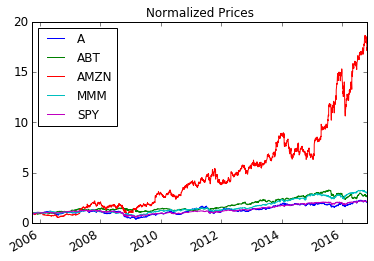

,A,ABT,AMZN,MMM,SPY
count,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000
mean,1.336932,1.800234,5.001607,1.644404,1.366566
std,0.422673,0.644733,4.220204,0.693259,0.421605
min,0.403141,0.893291,0.575497,0.624499,0.591138
25%,1.044473,1.314254,1.697406,1.122127,1.058163
50%,1.224938,1.458320,4.015232,1.353309,1.215380
75%,1.717051,2.381404,6.883830,2.248771,1.764273
max,2.297375,3.301615,18.639294,3.271610,2.220595


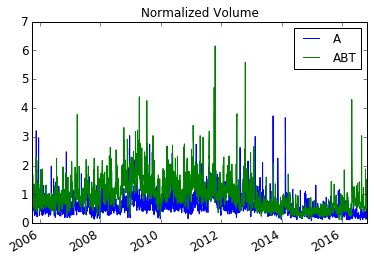

,A,ABT,AMZN,MMM,SPY
count,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000
mean,0.601752,0.980492,1.025267,1.877270,3.405313
std,0.342001,0.567681,0.886145,1.022565,2.163546
min,0.086457,0.115319,0.162550,0.352732,0.319294
25%,0.382434,0.571703,0.560143,1.233349,1.892200
50%,0.533068,0.882139,0.834932,1.616095,2.843638
75%,0.730279,1.242383,1.217801,2.228096,4.292064
max,3.730088,6.157193,17.227411,13.125768,18.213087


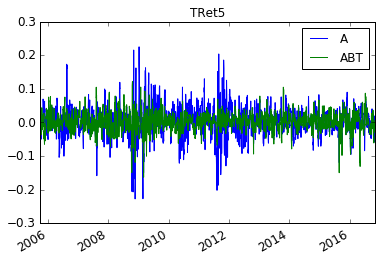

,A,ABT,AMZN,MMM,SPY
count,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000
mean,0.002309,0.002111,0.006754,0.002425,0.001737
std,0.043883,0.027736,0.056455,0.028717,0.024957
min,-0.227468,-0.162952,-0.238399,-0.184451,-0.197934
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,0.225134,0.121537,0.406362,0.178553,0.194036


In [356]:
''' Visualization and Exploration: plot and stats for normalized price and volume '''
def plot_data(df,title):
    ax = df.plot(title=title,fontsize=12)
    plt.show()

def plot_selected(df,columns,start_index,end_index):
    plot_data(df.ix[start_index:end_index,columns],title="Selected Data")

def normalize_data(df):
    return df / df.ix[-1,:]

# plot normalized price and volume
plot_data(normalize_data(features['Close'].ix[:,:5]),title="Normalized Price")
display(normalize_data(features['Close']).describe())

plot_data(normalize_data(features['Volume']).ix[:,:2],title="Normalized Volume")
display(normalize_data(features['Volume']).describe())

plot_data(features['TRet5'].ix[:,:2],title="TRet5")
display(features['TRet5'].describe())

In [205]:
''' Feature Engineering: create matrix of targets '''
def create_target_matrix(dates,FRet_list):
    # start the clock
    start = time()

    # create dictionary to hold dataframes for targets: dimension = [dates x tickers]
    targets = dict()
    
    df = features['Close']
    for i in FRet_list:
        targets['FRet'+str(i)] = 1 - (df.shift(i) / df)
        display(targets['FRet'+str(i)].ix[:10,:10])
        print 'FRet'+str(i)+' shape: ', targets['FRet'+str(i)].shape,'\n'
        
    total_time = time() - start
    print 'Target Data in {:.2f} seconds. {:.2f} seconds per stock.'.format(total_time, total_time/len(symbols))
    return targets

# number of days for forward return targets
FRet_list = [1,5]

# get targets
target_data = True
if target_data: targets = create_target_matrix(pd.date_range(start_date,end_date),FRet_list)  

# print list of possible targets 
target_list = []
for target in FRet_list: target_list.append('FRet'+str(target))
print '\nTarget List: ', target_list 

,A,ABT,AMZN,MMM,SPY
2016-11-01,NaN,NaN,NaN,NaN,NaN
2016-10-31,0.001836,0.004842,0.005584,0.006352,0.007245
2016-10-28,-0.008098,0.007587,-0.017390,0.002835,-0.000047
2016-10-27,0.003688,0.018615,0.051371,-0.000060,0.002955
2016-10-26,-0.000231,-0.008258,0.005142,0.004504,0.002667
2016-10-25,0.003218,0.005723,0.015075,-0.001684,0.002008
2016-10-24,0.051036,0.005444,0.003472,0.029427,0.003351
2016-10-21,-0.006144,0.002222,-0.023321,-0.010443,-0.004253
2016-10-20,0.010423,0.005891,-0.010699,0.002119,-0.000468
2016-10-19,-0.000652,-0.018246,0.009013,0.000294,0.001867


FRet1 shape:  (2792, 5) 



,A,ABT,AMZN,MMM,SPY
2016-11-01,NaN,NaN,NaN,NaN,NaN
2016-10-31,NaN,NaN,NaN,NaN,NaN
2016-10-28,NaN,NaN,NaN,NaN,NaN
2016-10-27,NaN,NaN,NaN,NaN,NaN
2016-10-26,NaN,NaN,NaN,NaN,NaN
2016-10-25,0.000460,0.028365,0.059592,0.011911,0.014755
2016-10-24,0.049727,0.028953,0.057595,0.034857,0.010889
2016-10-21,0.051569,0.023704,0.052101,0.022006,0.006730
2016-10-20,0.057980,0.011046,-0.009922,0.024138,0.003320
2016-10-19,0.057584,0.001250,-0.005993,0.020011,0.002520


FRet5 shape:  (2792, 5) 

Target Data in 0.03 seconds. 0.01 seconds per stock.

Target List:  ['FRet1', 'FRet5']


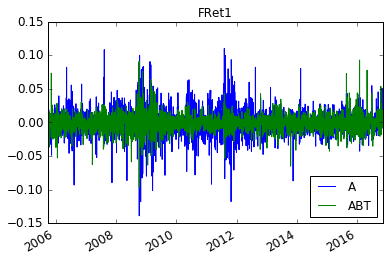

,A,ABT,AMZN,MMM,SPY
count,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000
mean,-0.000472,-0.000426,-0.001357,-0.000486,-0.000354
std,0.020577,0.012960,0.026068,0.013846,0.012632
min,-0.138790,-0.096259,-0.269497,-0.098784,-0.145198
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,0.110139,0.092908,0.218220,0.089569,0.098448


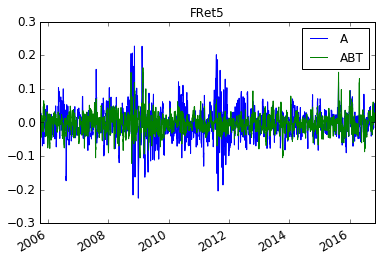

,A,ABT,AMZN,MMM,SPY
count,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000
mean,-0.002308,-0.002100,-0.006730,-0.002419,-0.001731
std,0.043876,0.027737,0.056459,0.028713,0.024955
min,-0.225134,-0.121537,-0.406362,-0.178553,-0.194036
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,0.227468,0.162952,0.238399,0.184451,0.197934


In [357]:
''' Visualization and Exploration: plot and stats for normalized price and volume '''
# plot normalized price and volume
plot_data(targets['FRet1'].ix[:,:2],title="FRet1")
display(targets['FRet1'].describe())

plot_data(targets['FRet5'].ix[:,:2],title="FRet5")
display(targets['FRet5'].describe())

In [390]:
''' Data Preprocessing: normalize features -- range = [0,1] - need to offset!! '''
def get_features_norm(features, feature_list):
    # start the clock
    start = time()
    
    features_norm, feature_list_norm = dict(), list()
    print feature_list,'\n'
    
    for feature in feature_list:
        index, columns = features[feature].index, features[feature].columns
    
        df = np.array(features[feature].ix[:,:])
        df_temp_H, df_temp_V = np.zeros((df.shape)), np.zeros((df.shape))

        for i in range(len(df)):
            for j in range(len(df[0])):
                df_temp_H[i,j] = stats.percentileofscore(df[i,:], df[i,j]) / 100
                df_temp_V[i,j] = stats.percentileofscore(df[i:,j], df[i,j]) / 100

        features_norm['H_'+feature] = pd.DataFrame(data=df_temp_H, index=index, columns=columns)
        features_norm['V_'+feature] = pd.DataFrame(data=df_temp_V, index=index, columns=columns)

    for feature in feature_list: feature_list_norm.append('H_'+feature)
    for feature in feature_list: feature_list_norm.append('V_'+feature)
    
    total_time = time() - start
    print 'Normalized in {:.2f} seconds. {:.2f} seconds per feature.'.format(total_time, total_time/len(feature_list))
    
    return features_norm, feature_list_norm

features_norm, feature_list_norm = get_features_norm(features,feature_list)

print '\nV_TRet5 shape:'+str(features_norm['V_TRet5'].shape)+'\n'
display(features_norm['V_TRet5'].head(10))
print '\nFeature List (Normalized):\n\n', feature_list_norm

['Volume', 'Close', 'TRet5', 'TRet10', 'TRet20', 'TRet40', 'TRet65', 'TRet130', 'TRet195', 'TRet260'] 

Normalized in 33.17 seconds. 3.32 seconds per feature.

V_TRet5 shape:(2792, 5)



,A,ABT,AMZN,MMM,SPY
2016-11-01,0.095272,0.099212,0.087751,0.082378,0.226361
2016-10-31,0.088857,0.137585,0.104264,0.151917,0.278395
2016-10-28,0.074194,0.279211,0.546595,0.136559,0.337634
2016-10-27,0.074937,0.438867,0.501255,0.167085,0.359269
2016-10-26,0.123027,0.137016,0.654232,0.151722,0.464849
2016-10-25,0.631145,0.381055,0.733046,0.546825,0.687478
2016-10-24,0.582556,0.340632,0.412419,0.353912,0.511845
2016-10-21,0.675045,0.357271,0.247756,0.421903,0.512029
2016-10-20,0.595546,0.138649,0.274784,0.457256,0.477011
2016-10-19,0.395257,0.573123,0.298599,0.467840,0.445562



Feature List (Normalized):

['H_Volume', 'H_Close', 'H_TRet5', 'H_TRet10', 'H_TRet20', 'H_TRet40', 'H_TRet65', 'H_TRet130', 'H_TRet195', 'H_TRet260', 'V_Volume', 'V_Close', 'V_TRet5', 'V_TRet10', 'V_TRet20', 'V_TRet40', 'V_TRet65', 'V_TRet130', 'V_TRet195', 'V_TRet260']


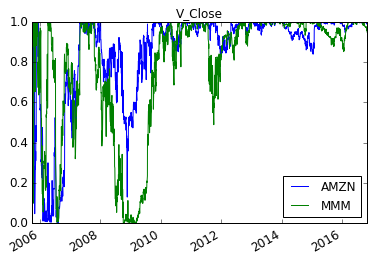

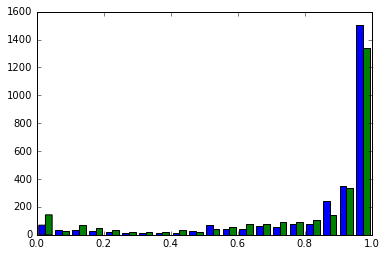

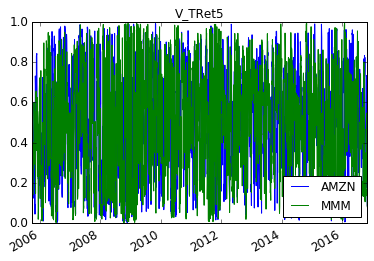

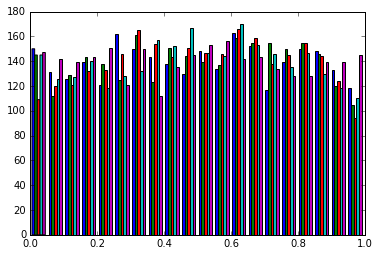

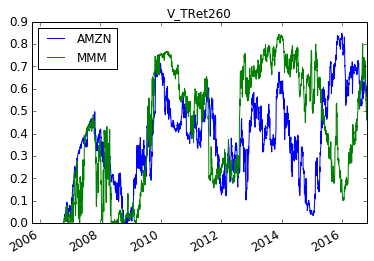

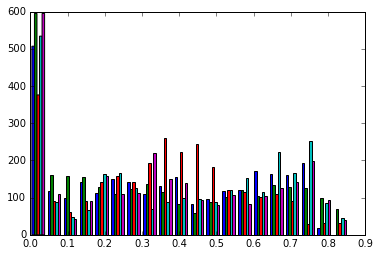

In [422]:
''' Visualization and Exploration: norm features '''
def plot_histogram(df):
    w = np.array(df)
    w[np.isnan(w)] = 0
    plt.hist(w,bins=20)
    plt.show()

plot_data(features_norm['V_Close'].ix[:,2:4],title="V_Close")
plot_histogram(features_norm['V_Close'].ix[:,2:4])
#display(features_norm['V_TRet5'].describe())

plot_data(features_norm['V_TRet5'].ix[:,2:4],title="V_TRet5")
plot_histogram(features_norm['V_TRet5'])
#display(features_norm['V_TRet5'].describe())

plot_data(features_norm['V_TRet260'].ix[:,2:4],title="V_TRet260")
plot_histogram(features_norm['V_TRet260'])
#display(features_norm['V_TRet260'].describe())

In [371]:
''' Data Preprocessing: normalize targets -- range = [0,1] - need to offset!! '''
def get_targets_norm(targets, target_list):
    return get_features_norm(targets,target_list)

targets_norm, target_list_norm = get_targets_norm(targets,target_list)
    
print '\nV_FRet5 shape:'+str(targets_norm['V_FRet5'].shape)+'\n'
display(targets_norm['V_FRet5'].head(10))
print '\nTarget List (Normalized):\n\n', target_list_norm

['FRet1', 'FRet5'] 

Normalized in 6.78 seconds. 3.39 seconds per feature.

V_FRet5 shape:(2792, 5)



,A,ABT,AMZN,MMM,SPY
2016-11-01,NaN,NaN,NaN,NaN,NaN
2016-10-31,NaN,NaN,NaN,NaN,NaN
2016-10-28,NaN,NaN,NaN,NaN,NaN
2016-10-27,NaN,NaN,NaN,NaN,NaN
2016-10-26,NaN,NaN,NaN,NaN,NaN
2016-10-25,0.545748,0.897381,0.916039,0.749910,0.816290
2016-10-24,0.904882,0.900933,0.912419,0.917803,0.773510
2016-10-21,0.911311,0.862478,0.895871,0.848115,0.721364
2016-10-20,0.926006,0.720546,0.452586,0.863506,0.661997
2016-10-19,0.925261,0.560546,0.498024,0.832914,0.640316



Target List (Normalized):

['H_FRet1', 'H_FRet5', 'V_FRet1', 'V_FRet5']


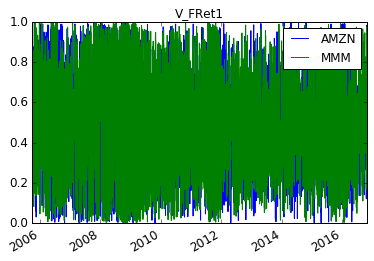

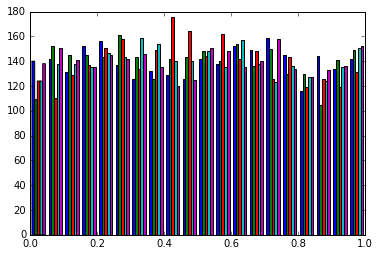

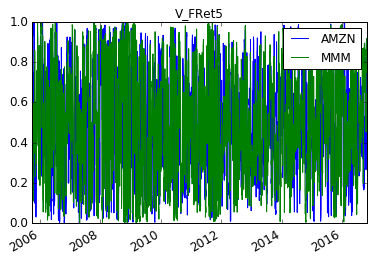

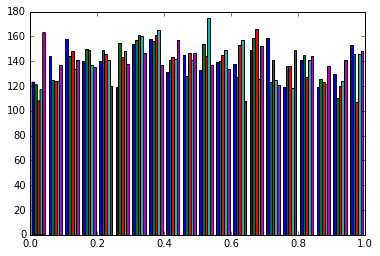

In [420]:
''' Visualization and Exploration: norm targets '''
def plot_histogram(df):
    w = np.array(df)
    w[np.isnan(w)] = 0
    plt.hist(w,bins=20)
    plt.show()

plot_data(targets_norm['V_FRet1'].ix[:,2:4],title="V_FRet1")
plot_histogram(targets_norm['V_FRet1'])
#display(targets_norm['V_FRet1'].describe())

plot_data(targets_norm['V_FRet5'].ix[:,2:4],title="V_FRet5")
plot_histogram(targets_norm['V_FRet5'])
#display(targets_norm['V_FRet5'].describe())

In [427]:
### need date index
print feature_list_norm
print
print target_list
print
print target_list_norm

['H_Volume', 'H_Close', 'H_TRet5', 'H_TRet10', 'H_TRet20', 'H_TRet40', 'H_TRet65', 'H_TRet130', 'H_TRet195', 'H_TRet260', 'V_Volume', 'V_Close', 'V_TRet5', 'V_TRet10', 'V_TRet20', 'V_TRet40', 'V_TRet65', 'V_TRet130', 'V_TRet195', 'V_TRet260']

['FRet1', 'FRet5']

['H_FRet1', 'H_FRet5', 'V_FRet1', 'V_FRet5']


In [423]:
### download data
### create features
### visualize features
### normalize features
### visualize norm features
### create and save norm_features_by_stock

# get all_data for X and y 
# save to file
# recursive feature elimination
# CAGR scoring function